In [1]:
import torch

torch_data = torch.load("data/celled/pdsi_iowa_60y_73x149")

In [6]:
numpy_data = torch_data.numpy()
numpy_data = numpy_data[:, 0, :, :]

In [7]:
numpy_data.shape

(720, 73, 149)

In [24]:
import pandas as pd
import numpy as np

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    print(data.shape)
    #n_vars = 1 if type(data) is list else data.shape[1]
    n_vars = 1
    df = pd.DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = pd.concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

In [11]:
!pip install xgboost

     |████████████████████████████████| 1.7 MB 1.8 MB/s eta 0:00:01


In [54]:
from sklearn.metrics import mean_absolute_error, r2_score
from xgboost import XGBRegressor


def xgboost_forecast(train, testX):
    # transform list into array
    train = np.asarray(train)
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    # fit model
    model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
    model.fit(trainX, trainy)
    # make a one-step prediction
    yhat = model.predict([testX])
    return yhat[0]

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]

def walk_forward_validation(data, n_test):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        # fit model on history and make a prediction
        yhat = xgboost_forecast(history, testX)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
        # summarize progress
        # print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
    # estimate prediction error
    #error = mean_absolute_error(test[:, -1], predictions)
    # estimate prediction error
    score = r2_score(test[:, -1], predictions)
    return score, test[:, 1], predictions

In [43]:
torch_data[:, 0, 12, 50]

tensor([ 2.3600e+00,  2.5900e+00,  2.5500e+00,  3.4400e+00,  3.0700e+00,
         2.3800e+00,  2.1600e+00,  1.8000e+00,  1.5700e+00,  6.4000e-01,
        -1.6800e+00, -2.2300e+00, -1.9100e+00, -7.8000e-01, -9.0000e-01,
        -1.3800e+00, -1.9100e+00, -9.8000e-01, -1.5100e+00,  1.5700e+00,
         1.6500e+00,  2.3300e+00,  2.6200e+00,  2.2500e+00,  2.8800e+00,
         2.9700e+00,  2.3100e+00,  2.5200e+00,  1.6900e+00,  2.8400e+00,
         2.5200e+00,  1.7400e+00,  1.5400e+00,  5.6000e-01, -1.8700e+00,
        -2.1000e+00, -2.4700e+00, -2.6000e+00, -2.3100e+00, -2.4400e+00,
        -3.3700e+00, -2.5000e+00, -2.1500e+00, -2.7700e+00, -3.6200e+00,
        -3.7100e+00, -4.0800e+00, -4.3700e+00, -4.8400e+00, -4.6100e+00,
        -3.6300e+00, -3.5400e+00, -2.9700e+00, -2.9300e+00, -2.9300e+00,
        -2.7300e+00, -3.6300e+00, -4.0100e+00, -4.0700e+00, -3.6000e+00,
        -3.2000e+00, -1.8600e+00, -6.8000e-01,  1.9300e+00,  1.9400e+00,
         1.4200e+00,  1.2700e+00,  3.2000e+00,  2.4

(720,)
>expected=-1.8, predicted=-2.1
>expected=-1.8, predicted=-1.8
>expected=-0.8, predicted=-1.9
>expected=-0.7, predicted=0.3
>expected=2.3, predicted=1.0
>expected=2.0, predicted=2.5
>expected=4.0, predicted=2.6
>expected=4.3, predicted=3.9
>expected=4.4, predicted=4.1
>expected=4.1, predicted=4.0
>expected=3.8, predicted=4.6
>expected=3.8, predicted=3.4
>expected=3.4, predicted=3.8
>expected=2.0, predicted=3.3
>expected=1.2, predicted=2.0
>expected=1.4, predicted=-1.6
>expected=2.5, predicted=1.1
>expected=3.4, predicted=2.7
>expected=3.7, predicted=2.9
>expected=4.0, predicted=3.5
>expected=3.4, predicted=4.0
>expected=3.8, predicted=3.1
>expected=4.7, predicted=3.7
>expected=4.3, predicted=4.4
>expected=4.0, predicted=4.3
>expected=3.5, predicted=3.6
>expected=2.8, predicted=3.2
>expected=2.5, predicted=3.1
>expected=1.6, predicted=2.9
>expected=1.8, predicted=1.0
>expected=2.5, predicted=1.1
>expected=2.6, predicted=1.8
>expected=2.6, predicted=2.4
>expected=2.0, predicted=2.6

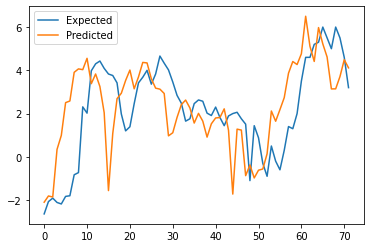

In [45]:
from matplotlib import pyplot

# load the dataset
values = numpy_data[:, 12, 50]
# transform the time series data into supervised learning
data = series_to_supervised(values, n_in=1, n_out=6)
# evaluate
r2, y, yhat = walk_forward_validation(data, 72)
print('R2: %.3f' % r2)
# plot expected vs preducted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()

In [58]:
r2_xgboost = np.zeros((30, 100))
from tqdm import tqdm
import time

with tqdm(total=10*10) as pbar:
    for x in tqdm(range(10)):
        for y in tqdm(range(10)):
            # load the dataset
            values = numpy_data[:, x, y]
            # transform the time series data into supervised learning
            data = series_to_supervised(values, n_in=1, n_out=6)
            # evaluate
            r2, true, yhat = walk_forward_validation(data, 72)
            print('R2: %.3f' % r2)
            print(x, y)
            r2_xgboost[x][y] = r2
            time.sleep(0.01)
            pbar.update(1)

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

(720,)


  1%|▊                                                                                 | 1/100 [00:27<45:26, 27.54s/it]

 10%|████████▎                                                                          | 1/10 [00:27<04:07, 27.55s/it]

R2: 0.797
0 0
(720,)


  2%|█▋                                                                                | 2/100 [00:55<45:00, 27.55s/it]

 20%|████████████████▌                                                                  | 2/10 [00:55<03:40, 27.55s/it]

R2: 0.863
0 1
(720,)


  3%|██▍                                                                               | 3/100 [01:21<43:25, 26.86s/it]

 30%|████████████████████████▉                                                          | 3/10 [01:21<03:08, 26.86s/it]

R2: 0.838
0 2
(720,)


  4%|███▎                                                                              | 4/100 [01:51<45:13, 28.26s/it]

 40%|█████████████████████████████████▏                                                 | 4/10 [01:51<02:49, 28.26s/it]

R2: 0.850
0 3
(720,)


  5%|████                                                                              | 5/100 [02:22<46:00, 29.05s/it]

 50%|█████████████████████████████████████████▌                                         | 5/10 [02:22<02:25, 29.05s/it]

R2: 0.840
0 4
(720,)


  6%|████▉                                                                             | 6/100 [02:48<44:24, 28.34s/it]

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [02:48<01:53, 28.34s/it]

R2: 0.831
0 5
(720,)


  7%|█████▋                                                                            | 7/100 [03:17<43:54, 28.32s/it]

 70%|██████████████████████████████████████████████████████████                         | 7/10 [03:17<01:24, 28.32s/it]

R2: 0.830
0 6
(720,)


  8%|██████▌                                                                           | 8/100 [03:45<43:32, 28.39s/it]

 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [03:45<00:56, 28.39s/it]

R2: 0.839
0 7
(720,)


  9%|███████▍                                                                          | 9/100 [04:22<47:06, 31.06s/it]

 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [04:22<00:31, 31.06s/it]

R2: 0.851
0 8
(720,)


 10%|████████                                                                         | 10/100 [04:51<45:45, 30.51s/it]

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [04:51<00:00, 29.20s/it]

 10%|████████▏                                                                         | 1/10 [04:51<43:47, 292.00s/it]

R2: 0.835
0 9




  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

(720,)


 11%|████████▉                                                                        | 11/100 [05:19<43:48, 29.54s/it]

 10%|████████▎                                                                          | 1/10 [00:27<04:06, 27.34s/it]

R2: 0.834
1 0
(720,)


 12%|█████████▋                                                                       | 12/100 [05:46<42:25, 28.93s/it]

 20%|████████████████▌                                                                  | 2/10 [00:54<03:39, 27.45s/it]

R2: 0.873
1 1
(720,)


 13%|██████████▌                                                                      | 13/100 [06:19<43:23, 29.92s/it]

 30%|████████████████████████▉                                                          | 3/10 [01:27<03:27, 29.62s/it]

R2: 0.851
1 2
(720,)


 14%|███████████▎                                                                     | 14/100 [06:48<42:32, 29.68s/it]

 40%|█████████████████████████████████▏                                                 | 4/10 [01:56<02:56, 29.42s/it]

R2: 0.847
1 3
(720,)


 15%|████████████▏                                                                    | 15/100 [07:17<41:43, 29.45s/it]

 50%|█████████████████████████████████████████▌                                         | 5/10 [02:25<02:26, 29.24s/it]

R2: 0.884
1 4
(720,)


 16%|████████████▉                                                                    | 16/100 [07:52<43:33, 31.11s/it]

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [03:00<02:04, 31.19s/it]

R2: 0.807
1 5
(720,)


 17%|█████████████▊                                                                   | 17/100 [08:21<42:09, 30.48s/it]

 70%|██████████████████████████████████████████████████████████                         | 7/10 [03:29<01:31, 30.47s/it]

R2: 0.821
1 6
(720,)


 18%|██████████████▌                                                                  | 18/100 [08:50<41:07, 30.09s/it]

 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [03:58<01:00, 30.06s/it]

R2: 0.828
1 7
(720,)


 19%|███████████████▍                                                                 | 19/100 [09:16<38:54, 28.82s/it]

 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [04:24<00:28, 28.75s/it]

R2: 0.813
1 8
(720,)


 20%|████████████████▏                                                                | 20/100 [09:43<37:54, 28.43s/it]

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [04:51<00:00, 29.16s/it]

 20%|████████████████▍                                                                 | 2/10 [09:43<38:54, 291.79s/it]

R2: 0.791
1 9




  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

(720,)


 21%|█████████████████                                                                | 21/100 [10:12<37:45, 28.67s/it]

 10%|████████▎                                                                          | 1/10 [00:29<04:23, 29.23s/it]

R2: 0.832
2 0
(720,)


 22%|█████████████████▊                                                               | 22/100 [10:41<37:14, 28.65s/it]

 20%|████████████████▌                                                                  | 2/10 [00:57<03:50, 28.85s/it]

R2: 0.815
2 1
(720,)


 23%|██████████████████▋                                                              | 23/100 [11:16<39:14, 30.58s/it]

 30%|████████████████████████▉                                                          | 3/10 [01:32<03:41, 31.70s/it]

R2: 0.869
2 2
(720,)


 24%|███████████████████▍                                                             | 24/100 [11:58<43:06, 34.04s/it]

 40%|█████████████████████████████████▏                                                 | 4/10 [02:15<03:34, 35.81s/it]

R2: 0.872
2 3
(720,)


 25%|████████████████████▎                                                            | 25/100 [12:38<44:32, 35.63s/it]

 50%|█████████████████████████████████████████▌                                         | 5/10 [02:54<03:05, 37.08s/it]

R2: 0.851
2 4
(720,)


 26%|█████████████████████                                                            | 26/100 [13:15<44:43, 36.26s/it]

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [03:32<02:29, 37.30s/it]

R2: 0.809
2 5
(720,)


 27%|█████████████████████▊                                                           | 27/100 [13:46<42:00, 34.53s/it]

 70%|██████████████████████████████████████████████████████████                         | 7/10 [04:02<01:45, 35.07s/it]

R2: 0.867
2 6
(720,)


 28%|██████████████████████▋                                                          | 28/100 [14:15<39:36, 33.01s/it]

 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [04:32<01:06, 33.29s/it]

R2: 0.800
2 7
(720,)


 29%|███████████████████████▍                                                         | 29/100 [14:47<38:42, 32.71s/it]

 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [05:04<00:32, 32.89s/it]

R2: 0.837
2 8
(720,)


 30%|████████████████████████▎                                                        | 30/100 [15:23<39:23, 33.77s/it]

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [05:40<00:00, 34.03s/it]

 30%|████████████████████████▌                                                         | 3/10 [15:23<36:37, 313.94s/it]

R2: 0.834
2 9




  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

(720,)


 31%|█████████████████████████                                                        | 31/100 [15:59<39:17, 34.16s/it]

 10%|████████▎                                                                          | 1/10 [00:35<05:15, 35.07s/it]

R2: 0.828
3 0
(720,)


 32%|█████████████████████████▉                                                       | 32/100 [16:30<37:47, 33.35s/it]

 20%|████████████████▌                                                                  | 2/10 [01:06<04:23, 32.94s/it]

R2: 0.828
3 1
(720,)


 33%|██████████████████████████▋                                                      | 33/100 [17:02<36:38, 32.81s/it]

 30%|████████████████████████▉                                                          | 3/10 [01:38<03:46, 32.31s/it]

R2: 0.865
3 2
(720,)


 34%|███████████████████████████▌                                                     | 34/100 [17:30<34:40, 31.52s/it]

 40%|█████████████████████████████████▏                                                 | 4/10 [02:06<03:04, 30.81s/it]

R2: 0.876
3 3
(720,)


 35%|████████████████████████████▎                                                    | 35/100 [17:59<33:16, 30.72s/it]

 50%|█████████████████████████████████████████▌                                         | 5/10 [02:35<02:30, 30.10s/it]

R2: 0.831
3 4
(720,)


 36%|█████████████████████████████▏                                                   | 36/100 [18:30<32:51, 30.80s/it]

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [03:06<02:01, 30.41s/it]

R2: 0.826
3 5
(720,)


 37%|█████████████████████████████▉                                                   | 37/100 [19:06<34:02, 32.41s/it]

 70%|██████████████████████████████████████████████████████████                         | 7/10 [03:42<01:36, 32.29s/it]

R2: 0.794
3 6
(720,)


 38%|██████████████████████████████▊                                                  | 38/100 [19:39<33:42, 32.62s/it]

 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [04:15<01:05, 32.55s/it]

R2: 0.813
3 7
(720,)


 39%|███████████████████████████████▌                                                 | 39/100 [20:13<33:28, 32.93s/it]

 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [04:49<00:32, 32.90s/it]

R2: 0.816
3 8
(720,)


 40%|████████████████████████████████▍                                                | 40/100 [20:43<32:06, 32.12s/it]

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [05:19<00:00, 31.96s/it]

 40%|████████████████████████████████▊                                                 | 4/10 [20:43<31:37, 316.18s/it]

R2: 0.865
3 9




  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

(720,)


 41%|█████████████████████████████████▏                                               | 41/100 [21:13<30:52, 31.41s/it]

 10%|████████▎                                                                          | 1/10 [00:29<04:27, 29.71s/it]

R2: 0.892
4 0
(720,)


 42%|██████████████████████████████████                                               | 42/100 [21:41<29:24, 30.43s/it]

 20%|████████████████▌                                                                  | 2/10 [00:57<03:50, 28.79s/it]

R2: 0.875
4 1
(720,)


 43%|██████████████████████████████████▊                                              | 43/100 [22:23<32:07, 33.82s/it]

 30%|████████████████████████▉                                                          | 3/10 [01:39<04:02, 34.70s/it]

R2: 0.887
4 2
(720,)


 44%|███████████████████████████████████▋                                             | 44/100 [23:02<33:14, 35.61s/it]

 40%|█████████████████████████████████▏                                                 | 4/10 [02:19<03:40, 36.71s/it]

R2: 0.862
4 3
(720,)


 45%|████████████████████████████████████▍                                            | 45/100 [23:37<32:25, 35.37s/it]

 50%|█████████████████████████████████████████▌                                         | 5/10 [02:54<03:00, 36.02s/it]

R2: 0.831
4 4
(720,)


 46%|█████████████████████████████████████▎                                           | 46/100 [24:09<30:53, 34.33s/it]

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [03:26<02:18, 34.62s/it]

R2: 0.833
4 5
(720,)


 47%|██████████████████████████████████████                                           | 47/100 [24:37<28:39, 32.44s/it]

 70%|██████████████████████████████████████████████████████████                         | 7/10 [03:54<01:37, 32.47s/it]

R2: 0.845
4 6
(720,)


 48%|██████████████████████████████████████▉                                          | 48/100 [25:08<27:43, 32.00s/it]

 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [04:25<01:04, 32.00s/it]

R2: 0.855
4 7
(720,)


 49%|███████████████████████████████████████▋                                         | 49/100 [25:42<27:38, 32.51s/it]

 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [04:58<00:32, 32.52s/it]

R2: 0.833
4 8
(720,)


 50%|████████████████████████████████████████▌                                        | 50/100 [26:10<26:04, 31.29s/it]

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [05:27<00:00, 32.72s/it]

 50%|█████████████████████████████████████████                                         | 5/10 [26:10<26:40, 320.17s/it]

R2: 0.824
4 9




  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

(720,)


 51%|█████████████████████████████████████████▎                                       | 51/100 [26:40<25:03, 30.69s/it]

 10%|████████▎                                                                          | 1/10 [00:29<04:23, 29.30s/it]

R2: 0.872
5 0
(720,)


 52%|██████████████████████████████████████████                                       | 52/100 [27:08<24:04, 30.10s/it]

 20%|████████████████▌                                                                  | 2/10 [00:58<03:51, 28.95s/it]

R2: 0.896
5 1
(720,)


 53%|██████████████████████████████████████████▉                                      | 53/100 [27:34<22:28, 28.70s/it]

 30%|████████████████████████▉                                                          | 3/10 [01:23<03:11, 27.35s/it]

R2: 0.852
5 2
(720,)


 54%|███████████████████████████████████████████▋                                     | 54/100 [27:59<21:17, 27.78s/it]

 40%|█████████████████████████████████▏                                                 | 4/10 [01:49<02:40, 26.67s/it]

R2: 0.835
5 3
(720,)


 55%|████████████████████████████████████████████▌                                    | 55/100 [28:26<20:34, 27.44s/it]

 50%|█████████████████████████████████████████▌                                         | 5/10 [02:15<02:13, 26.66s/it]

R2: 0.841
5 4
(720,)


 56%|█████████████████████████████████████████████▎                                   | 56/100 [28:56<20:46, 28.32s/it]

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [02:46<01:51, 27.93s/it]

R2: 0.808
5 5
(720,)


 57%|██████████████████████████████████████████████▏                                  | 57/100 [29:24<20:05, 28.03s/it]

 70%|██████████████████████████████████████████████████████████                         | 7/10 [03:13<01:23, 27.74s/it]

R2: 0.801
5 6
(720,)


 58%|██████████████████████████████████████████████▉                                  | 58/100 [29:49<19:00, 27.15s/it]

 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [03:38<00:53, 26.89s/it]

R2: 0.850
5 7
(720,)


 59%|███████████████████████████████████████████████▊                                 | 59/100 [30:13<17:58, 26.30s/it]

 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [04:02<00:26, 26.09s/it]

R2: 0.798
5 8
(720,)


 60%|████████████████████████████████████████████████▌                                | 60/100 [30:37<17:07, 25.69s/it]

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [04:27<00:00, 26.71s/it]

 60%|█████████████████████████████████████████████████▏                                | 6/10 [30:37<20:08, 302.14s/it]

R2: 0.833
5 9




  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

(720,)


 61%|█████████████████████████████████████████████████▍                               | 61/100 [31:04<16:57, 26.09s/it]

 10%|████████▎                                                                          | 1/10 [00:27<04:03, 27.02s/it]

R2: 0.854
6 0
(720,)


 62%|██████████████████████████████████████████████████▏                              | 62/100 [31:33<17:00, 26.84s/it]

 20%|████████████████▌                                                                  | 2/10 [00:55<03:43, 27.95s/it]

R2: 0.818
6 1
(720,)


 63%|███████████████████████████████████████████████████                              | 63/100 [32:03<17:06, 27.75s/it]

 30%|████████████████████████▉                                                          | 3/10 [01:25<03:21, 28.83s/it]

R2: 0.857
6 2
(720,)


 64%|███████████████████████████████████████████████████▊                             | 64/100 [32:34<17:17, 28.82s/it]

 40%|█████████████████████████████████▏                                                 | 4/10 [01:56<02:58, 29.81s/it]

R2: 0.837
6 3
(720,)


 65%|████████████████████████████████████████████████████▋                            | 65/100 [33:04<16:59, 29.12s/it]

 50%|█████████████████████████████████████████▌                                         | 5/10 [02:26<02:29, 29.81s/it]

R2: 0.813
6 4
(720,)


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [33:31<16:09, 28.52s/it]

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [02:53<01:55, 28.89s/it]

R2: 0.818
6 5
(720,)


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [34:08<17:04, 31.04s/it]

 70%|██████████████████████████████████████████████████████████                         | 7/10 [03:30<01:34, 31.52s/it]

R2: 0.805
6 6
(720,)


 68%|███████████████████████████████████████████████████████                          | 68/100 [34:42<16:59, 31.85s/it]

 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [04:04<01:04, 32.22s/it]

R2: 0.806
6 7
(720,)


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [35:14<16:26, 31.83s/it]

 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [04:36<00:32, 32.09s/it]

R2: 0.804
6 8
(720,)


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [35:43<15:34, 31.14s/it]

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [05:05<00:00, 30.57s/it]

 70%|█████████████████████████████████████████████████████████▍                        | 7/10 [35:43<15:09, 303.31s/it]

R2: 0.812
6 9




  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

(720,)


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [36:12<14:40, 30.38s/it]

 10%|████████▎                                                                          | 1/10 [00:28<04:17, 28.58s/it]

R2: 0.857
7 0
(720,)


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [36:38<13:32, 29.03s/it]

 20%|████████████████▌                                                                  | 2/10 [00:54<03:35, 27.00s/it]

R2: 0.858
7 1
(720,)


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [37:10<13:32, 30.08s/it]

 30%|████████████████████████▉                                                          | 3/10 [01:27<03:26, 29.53s/it]

R2: 0.837
7 2
(720,)


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [37:42<13:14, 30.54s/it]

 40%|█████████████████████████████████▏                                                 | 4/10 [01:58<03:02, 30.35s/it]

R2: 0.825
7 3
(720,)


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [38:12<12:42, 30.52s/it]

 50%|█████████████████████████████████████████▌                                         | 5/10 [02:29<02:31, 30.39s/it]

R2: 0.776
7 4
(720,)


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [38:43<12:17, 30.73s/it]

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [03:00<02:02, 30.68s/it]

R2: 0.808
7 5
(720,)


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [39:10<11:14, 29.34s/it]

 70%|██████████████████████████████████████████████████████████                         | 7/10 [03:26<01:27, 29.17s/it]

R2: 0.803
7 6
(720,)


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [39:38<10:37, 29.00s/it]

 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [03:54<00:57, 28.87s/it]

R2: 0.842
7 7
(720,)


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [40:07<10:11, 29.10s/it]

 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [04:23<00:29, 29.02s/it]

R2: 0.817
7 8
(720,)


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [40:40<10:04, 30.20s/it]

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [04:56<00:00, 29.67s/it]

 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [40:40<10:02, 301.22s/it]

R2: 0.831
7 9




  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

(720,)


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [41:10<09:35, 30.29s/it]

 10%|████████▎                                                                          | 1/10 [00:30<04:34, 30.48s/it]

R2: 0.866
8 0
(720,)


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [41:47<09:41, 32.28s/it]

 20%|████████████████▌                                                                  | 2/10 [01:07<04:34, 34.27s/it]

R2: 0.849
8 1
(720,)


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [42:22<09:22, 33.09s/it]

 30%|████████████████████████▉                                                          | 3/10 [01:42<04:02, 34.60s/it]

R2: 0.850
8 2
(720,)


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [42:56<08:50, 33.16s/it]

 40%|█████████████████████████████████▏                                                 | 4/10 [02:15<03:24, 34.09s/it]

R2: 0.827
8 3
(720,)


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [43:29<08:17, 33.17s/it]

 50%|█████████████████████████████████████████▌                                         | 5/10 [02:48<02:48, 33.77s/it]

R2: 0.812
8 4
(720,)


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [43:54<07:12, 30.90s/it]

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [03:14<02:03, 31.00s/it]

R2: 0.831
8 5
(720,)


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [44:20<06:20, 29.28s/it]

 70%|██████████████████████████████████████████████████████████                         | 7/10 [03:40<01:27, 29.20s/it]

R2: 0.822
8 6
(720,)


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [44:48<05:47, 28.96s/it]

 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [04:08<00:57, 28.88s/it]

R2: 0.809
8 7
(720,)


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [45:14<05:10, 28.18s/it]

 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [04:34<00:28, 28.10s/it]

R2: 0.778
8 8
(720,)


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [45:38<04:26, 26.64s/it]

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [04:57<00:00, 29.76s/it]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 9/10 [45:38<05:00, 300.10s/it]

R2: 0.822
8 9




  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

(720,)


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [46:00<03:47, 25.31s/it]

 10%|████████▎                                                                          | 1/10 [00:22<03:19, 22.20s/it]

R2: 0.840
9 0
(720,)


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [46:23<03:16, 24.59s/it]

 20%|████████████████▌                                                                  | 2/10 [00:45<03:00, 22.62s/it]

R2: 0.845
9 1
(720,)


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [46:51<03:00, 25.77s/it]

 30%|████████████████████████▉                                                          | 3/10 [01:13<02:57, 25.32s/it]

R2: 0.834
9 2
(720,)


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [47:18<02:37, 26.18s/it]

 40%|█████████████████████████████████▏                                                 | 4/10 [01:40<02:36, 26.03s/it]

R2: 0.811
9 3
(720,)


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [47:48<02:16, 27.30s/it]

 50%|█████████████████████████████████████████▌                                         | 5/10 [02:10<02:17, 27.43s/it]

R2: 0.844
9 4
(720,)


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [48:20<01:54, 28.71s/it]

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [02:42<01:55, 28.99s/it]

R2: 0.853
9 5
(720,)


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [48:57<01:33, 31.04s/it]

 70%|██████████████████████████████████████████████████████████                         | 7/10 [03:19<01:34, 31.44s/it]

R2: 0.842
9 6
(720,)


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [49:28<01:01, 30.98s/it]

 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [03:50<01:02, 31.26s/it]

R2: 0.856
9 7
(720,)


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [49:59<00:31, 31.11s/it]

 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [04:21<00:31, 31.29s/it]

R2: 0.886
9 8
(720,)


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [50:28<00:00, 30.49s/it]

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [04:50<00:00, 29.05s/it]

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [50:28<00:00, 30.29s/it]

R2: 0.849
9 9


In [52]:
r2_xgboost[0][50]

0.0

<AxesSubplot:>

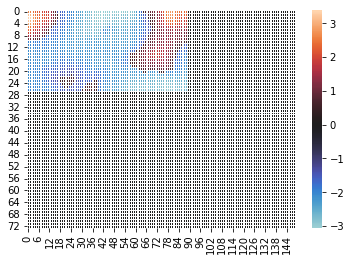

In [47]:
import seaborn as sns
sns.heatmap(numpy_data[11,:,:], linewidth=0.5, center = 0)

<AxesSubplot:>

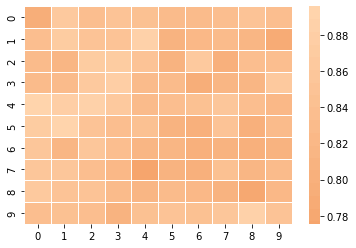

In [59]:
import seaborn as sns
sns.heatmap(r2_xgboost[:10,:10], linewidth=0.5, center = 0)

<AxesSubplot:>

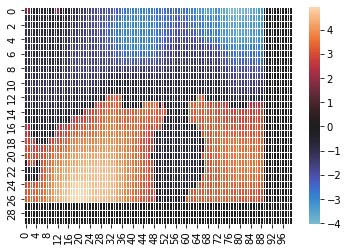

In [62]:
import seaborn as sns
sns.heatmap(numpy_data[213,:30,:100], linewidth=0.5, center = 0)